Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install ..  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# Redes Densamente Conectadas (DenseNet)

A ResNet mudou significativamente a visão de como parametrizar as funções em redes profundas. *DenseNet* (rede convolucional densa) é, até certo ponto, a extensão lógica disso :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
Para entender como chegar a isso, façamos um pequeno desvio para a matemática.

## De ResNet para DenseNet

Lembre-se da expansão de Taylor para funções. Para o ponto $x = 0$, pode ser escrito como

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

O ponto principal é que ele decompõe uma função em termos de ordem cada vez mais elevados. De maneira semelhante, o ResNet decompõe funções em

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

Ou seja, o ResNet decompõe $f$ em um termo linear simples e um termo mais complexo
não linear.
E se quisermos capturar (não necessariamente adicionar) informações além de dois termos?
Uma solução foi
DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![A principal diferença entre ResNet (esquerda) e DenseNet (direita) em conexões de camada cruzada: uso de adição e uso de concatenação. ](../img/densenet-block.svg)
:label:`fig_densenet_block`

Conforme mostrado em :numref:`fig_densenet_block`, a principal diferença entre ResNet e DenseNet é que, no último caso, as saídas são *concatenadas* (denotadas por $[,]$) em vez de adicionadas.
Como resultado, realizamos um mapeamento de $\mathbf {x}$ para seus valores após aplicar uma sequência cada vez mais complexa de funções:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

No final, todas essas funções são combinadas no MLP para reduzir o número de recursos novamente. Em termos de implementação, isso é bastante simples:
em vez de adicionar termos, nós os concatenamos. O nome DenseNet surge do fato de o gráfico de dependência entre as variáveis se tornar bastante denso. A última camada de tal cadeia está densamente conectada a todas as camadas anteriores. As conexões densas são mostradas em :numref:`fig_densenet`.

![Conexões densas na DenseNet.](../img/densenet.svg)
:label:`fig_densenet`


Os principais componentes que compõem uma DenseNet são *blocos densos* e *camadas de transição*. O primeiro define como as entradas e saídas são concatenadas, enquanto o último controla o número de canais para que não seja muito grande.

## Blocos Densos

A DenseNet usa a "normalização, ativação e convolução em lote" modificada
estrutura do ResNet (veja o exercício em :numref:`sec_resnet`).
Primeiro, implementamos essa estrutura de bloco de convolução.


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

Um *bloco denso* consiste em vários blocos de convolução, cada um usando o mesmo número de canais de saída. Na propagação direta, entretanto, concatenamos a entrada e a saída de cada bloco de convolução na dimensão do canal.


In [2]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super().__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = np.concatenate((X, Y), axis=1)
        return X

No exemplo a seguir,
definimos uma instância `DenseBlock` com 2 blocos de convolução de 10 canais de saída.
Ao usar uma entrada com 3 canais, obteremos uma saída com $3+2\times 10=23$ canais. O número de canais de bloco de convolução controla o crescimento do número de canais de saída em relação ao número de canais de entrada. Isso também é conhecido como *taxa de crescimento*.


In [3]:
blk = DenseBlock(2, 10)
blk.initialize()
X = np.random.uniform(size=(4, 3, 8, 8))
Y = blk(X)
Y.shape

(4, 23, 8, 8)

## Camadas de Transição

Uma vez que cada bloco denso aumentará o número de canais, adicionar muitos deles levará a um modelo excessivamente complexo. Uma *camada de transição* é usada para controlar a complexidade do modelo. Ele reduz o número de canais usando a camada convolucional $1\times 1$ e divide pela metade a altura e a largura da camada de pooling média com uma distância de 2, reduzindo ainda mais a complexidade do modelo.


In [4]:
def transition_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

Aplique uma camada de transição com 10 canais à saída do bloco denso no exemplo anterior. Isso reduz o número de canais de saída para 10 e divide a altura e a largura pela metade.


In [5]:
blk = transition_block(10)
blk.initialize()
blk(Y).shape

(4, 10, 4, 4)

## Modelo DenseNet 

A seguir, construiremos um modelo DenseNet. A DenseNet usa primeiro a mesma camada convolucional única e camada máxima de pooling que no ResNet.


In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

Então, semelhante aos quatro módulos compostos de blocos residuais que o ResNet usa,
A DenseNet usa quatro blocos densos.
Semelhante ao ResNet, podemos definir o número de camadas convolucionais usadas em cada bloco denso. Aqui, nós o definimos como 4, consistente com o modelo ResNet-18 em :numref:`sec_resnet`. Além disso, definimos o número de canais (ou seja, taxa de crescimento) para as camadas convolucionais no bloco denso para 32, de modo que 128 canais serão adicionados a cada bloco denso.

No ResNet, a altura e a largura são reduzidas entre cada módulo por um bloco residual com uma distância de 2. Aqui, usamos a camada de transição para reduzir pela metade a altura e a largura e pela metade o número de canais.


In [7]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        num_channels //= 2
        net.add(transition_block(num_channels))

Semelhante ao ResNet, uma camada de pooling global e uma camada totalmente conectada são conectadas na extremidade para produzir a saída.


In [8]:
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))

## Treinamento

Como estamos usando uma rede mais profunda aqui, nesta seção, reduziremos a altura e largura de entrada de 224 para 96 para simplificar o cálculo.


loss 0.142, train acc 0.948, test acc 0.870
5061.2 examples/sec on gpu(0)


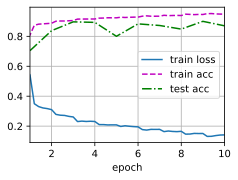

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* Em termos de conexões entre camadas, ao contrário do ResNet, onde entradas e saídas são adicionadas, o DenseNet concatena entradas e saídas na dimensão do canal.
* Os principais componentes que compõem o DenseNet são blocos densos e camadas de transição.
* Precisamos manter a dimensionalidade sob controle ao compor a rede, adicionando camadas de transição que reduzem o número de canais novamente.

## Exercícios

1. Por que usamos pooling médio em vez de pooling máximo na camada de transição?
1. Uma das vantagens mencionadas no artigo da DenseNet é que seus parâmetros de modelo são menores que os do ResNet. Por que isso acontece?
1. Um problema pelo qual a DenseNet foi criticada é o alto consumo de memória.
     1. Este é realmente o caso? Tente alterar a forma de entrada para $224\times 224$ para ver o consumo real de memória da GPU.
     1. Você consegue pensar em um meio alternativo de reduzir o consumo de memória? Como você precisa mudar a estrutura?
1. Implemente as várias versões da DenseNet apresentadas na Tabela 1 do artigo da DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
1. Projete um modelo baseado em MLP aplicando a ideia DenseNet. Aplique-o à tarefa de previsão do preço da habitação em :numref:`sec_kaggle_house`.


[Discussão](https://discuss.d2l.ai/t/87)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTU4NDQ5NzczMywxODU5NDAxOTcxXX0=
-->
